In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

- Pneumonia is a very common disease. It can be either: 1) Bacterial pneumonia 2) Viral Pneumonia 3) Mycoplasma pneumonia and 4) Fungal pneumonia. This dataset consists pneumonia samples belonging to the first two classes. The dataset consists of only very few samples and that too unbalanced. The aim of this kernel is to develop a robust deep learning model from scratch on this limited amount of data. We all know that deep learning models are data hungry but if you know how things work, you can build good models even with a limited amount of data.

## Set up

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("../input/chest-xray-pneumonia/chest_xray")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [3]:
print(len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")))
print(len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")))

3875
1341


The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

In [4]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


# Image preprocessing

Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images. We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution). The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [5]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
)

# Build a separate generator fo valid and test sets

In [6]:
IMG_SIZE = 256

In [7]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(IMG_SIZE, IMG_SIZE))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(IMG_SIZE, IMG_SIZE))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(IMG_SIZE, IMG_SIZE))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 256 pixels width and 256 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 116.9355 and the standard deviation is 60.3918


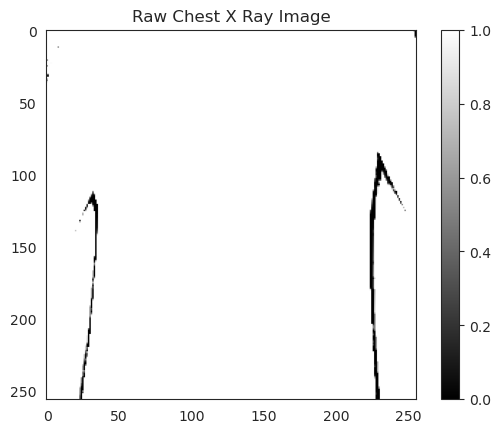

In [8]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

# Model building

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras import Model

In [10]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [11]:
def unet_combination_build(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    # U-net block
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    # Classification layer (classical CNN)
    # conv block 32
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(conv10)
    batch1 = BatchNormalization()(cnn_conv1)
    cnn_conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_conv1)
    batch2 = BatchNormalization()(cnn_conv2)
    pooling1 = MaxPool2D(pool_size=(2, 2))(cnn_conv2)
    dropout1 = Dropout(0.2)(pooling1)
    
    # conv block 64
    cnn_conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pooling1)
    batch3 = BatchNormalization()(cnn_conv3)
    cnn_conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_conv3)
    batch4 = BatchNormalization()(cnn_conv4)
    pooling2 = MaxPool2D(pool_size=(2, 2))(cnn_conv4)
    dropout2 = Dropout(0.2)(pooling2)

    # conv block 128
    cnn_conv5 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pooling2)
    batch5 = BatchNormalization()(cnn_conv5)
    cnn_conv6 = Conv2D(128, kernel_size=(3, 3), activation='relu')(cnn_conv5)
    batch6 = BatchNormalization()(cnn_conv6)
    pooling3 = MaxPool2D(pool_size=(2, 2))(cnn_conv6)
    dropout3 = Dropout(0.2)(pooling3)
    
    flatten = Flatten()(pooling3)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [12]:
# def conv_block(filters, dropout_rate):
#     block = Sequential([
#         Conv2D(filters, kernel_size=(3, 3), activation='relu'),
#         BatchNormalization(),
#         Conv2D(filters, kernel_size=(3, 3), activation='relu'),
#         BatchNormalization(),
#         MaxPool2D(pool_size=(2, 2)),
#         Dropout(dropout_rate)
#     ])
    
#     return block

In [13]:
# def dense_block(units, dropout_rate):
#     block = Sequential([
#         Dense(units, activation='relu'),
#         BatchNormalization(),
#         Dropout(dropout_rate)
#     ])
    
#     return block

In [14]:
# def build_model():
#     model = Sequential([
# #         # init conv
# #         Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'),
# #         BatchNormalization(),
# #         Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'),
# #         BatchNormalization(),
# #         MaxPool2D(pool_size=(2, 2)),
#         # init U-net
#         unet_block(),

#         # conv block
#         conv_block(64, 0.2),
#         conv_block(128, 0.2),

#         Flatten(),

#         # Dense block
#         dense_block(128, 0.2),

#         Dense(1, activation='sigmoid')
#     ])
    
#     return model

In [15]:
model = unet_combination_build()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [17]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [18]:
history = model.fit(
    train, 
    epochs=30,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/30
100/100 [==============================] - 50s 283ms/step - loss: 0.2692 - accuracy: 0.4812 - precision: 0.7520 - recall: 0.4600 - val_loss: 0.7012 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 26s 262ms/step - loss: 0.2776 - accuracy: 0.5225 - precision: 0.8028 - recall: 0.4774
Epoch 3/30
100/100 [==============================] - 27s 267ms/step - loss: 0.2625 - accuracy: 0.6775 - precision: 0.7457 - recall: 0.8650
Epoch 4/30
100/100 [==============================] - 25s 250ms/step - loss: 0.2739 - accuracy: 0.6513 - precision: 0.7137 - recall: 0.8569
Epoch 5/30
100/100 [==============================] - 24s 238ms/step - loss: 0.2670 - accuracy: 0.2637 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/30
100/100 [==============================] - 24s 241ms/step - loss: 0.2683 - accuracy: 0.2675 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/30
100/100 [=============================

## Predict and evaluation

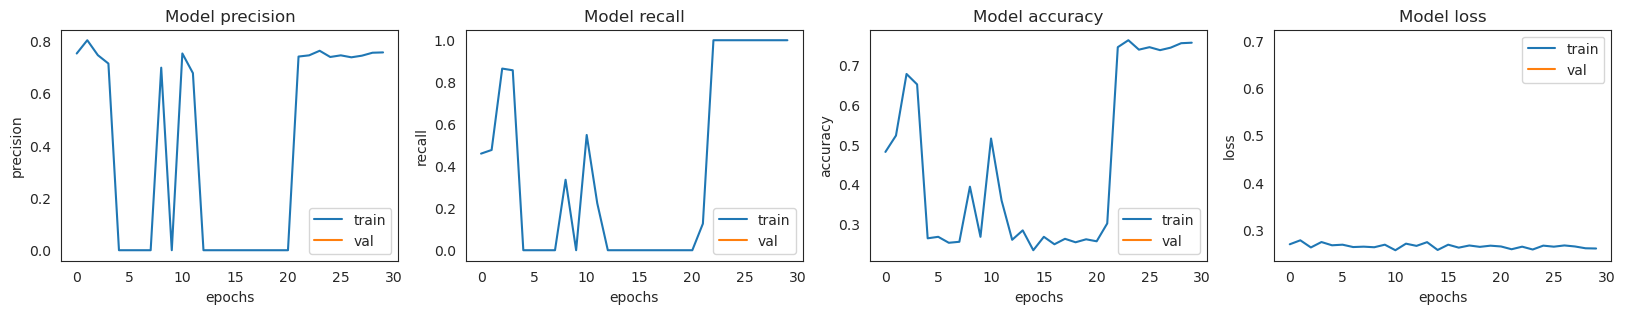

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, acc, prec, rec = model.evaluate(test)

624/624 [==============================] - 18s 29ms/step - loss: 0.6907 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
